# Test notebook for functional regression

## Importing

In [51]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler

from skfda.ml.regression import KNeighborsRegressor
from skfda.representation.basis import FourierBasis

from skfda.representation.grid import FDataGrid

from sklearn.metrics import root_mean_squared_error as rmse



## Files Reading

In [52]:
ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')
ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/external_inputs.nc')

ds = ds.isel(time_counter = (np.arange(0, len(ds.time_counter),2)), 
    y=(np.arange(ds.y[0], ds.y[-1], 5)), 
    x=(np.arange(ds.x[0], ds.x[-1], 5)))

ds2 = ds2.isel(time_counter = (np.arange(0, len(ds2.time_counter),2)), 
    y=(np.arange(ds2.y[0], ds2.y[-1], 5)), 
    x=(np.arange(ds2.x[0], ds2.x[-1], 5)))

dataset = ds.sel(time_counter = slice('2007', '2007'))
dataset2 = ds2.sel(time_counter = slice('2007', '2007'))


## Datasets Preparation

In [53]:
test = np.stack([np.reshape(np.ravel(dataset['Temperature_(0m-15m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset['Temperature_(15m-100m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset['Salinity_(0m-15m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset['Salinity_(15m-100m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset2['Summation_of_solar_radiation']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset2['Mean_wind_speed']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset2['Mean_air_temperature']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    ])

x =  np.tile(dataset.x, len(dataset.y))
y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

indx = np.where((~np.isnan(test[1]).any(axis=0)) & (x>10) & ((x>100) | (y<880)))
test = test[:,:,indx[0]]

test[0] = minmax_scale(test[0])
test[1] = minmax_scale(test[1])
test[2] = minmax_scale(test[2])
test[3] = minmax_scale(test[3])
test[4] = minmax_scale(test[4])
test[5] = minmax_scale(test[5])
test[6] = minmax_scale(test[6])

test2 = np.reshape(np.ravel(dataset['Diatom_Production_Rate']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x)))
test2 = test2[:,indx[0]]

scaler0 = MinMaxScaler()
test2 = scaler0.fit_transform(test2)
test2 = test2.transpose()


In [54]:
input = np.transpose(test,axes=(2,1,0))
input = FDataGrid(data_matrix=input, grid_points=np.arange(0,len(dataset.time_counter)))
target = FDataGrid(data_matrix=test2, grid_points=np.arange(0,len(dataset.time_counter)))

target = target.to_basis(FourierBasis(n_basis=5))


## Training 

In [55]:

knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(input, target)

KNeighborsRegressor(n_neighbors=10, weights='distance')

In [56]:
dataset = ds.sel(time_counter = slice('2008', '2008'))
dataset2 = ds2.sel(time_counter = slice('2008', '2008'))


test = np.stack([np.reshape(np.ravel(dataset['Temperature_(0m-15m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset['Temperature_(15m-100m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset['Salinity_(0m-15m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset['Salinity_(15m-100m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset2['Summation_of_solar_radiation']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset2['Mean_wind_speed']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset2['Mean_air_temperature']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    ])

x =  np.tile(dataset.x, len(dataset.y))
y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

indx = np.where((~np.isnan(test[1]).any(axis=0)) & (x>10) & ((x>100) | (y<880)))
test = test[:,:,indx[0]]

test[0] = minmax_scale(test[0])
test[1] = minmax_scale(test[1])
test[2] = minmax_scale(test[2])
test[3] = minmax_scale(test[3])
test[4] = minmax_scale(test[4])
test[5] = minmax_scale(test[5])
test[6] = minmax_scale(test[6])

test2 = np.reshape(np.ravel(dataset['Diatom_Production_Rate']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x)))
test2 = test2[:,indx[0]]

test2 = test2.transpose()

input = np.transpose(test,axes=(2,1,0))
input = FDataGrid(data_matrix=input, grid_points=np.arange(0,len(dataset.time_counter)))

y_pred = knn.predict(input)

basis = FourierBasis(domain_range=(0, len(dataset.time_counter)),n_basis=5)
x = y_pred.to_basis(basis)
y = np.array(x.to_grid(np.arange(0,len(dataset.time_counter))).data_matrix)
b = np.squeeze(y,2)
b = scaler0.inverse_transform(b.transpose())
b = b.transpose()

print(np.corrcoef(np.ravel(test2), np.ravel(b))[0][1])
print(rmse(np.ravel(test2),np.ravel(b)))


0.5772241762049454
1.2154812114064862e-06


In [57]:
b.shape

(1838, 38)

In [58]:
for i in np.arange(0,38):
    print(rmse(b[:,i], test2[:,i]))

1.1689417402654882e-06
4.7339482951941836e-07
5.519279450069298e-07
6.346795909047602e-07
8.399274347581504e-07
7.200320382795917e-07
1.338629589967847e-06
5.53794337996868e-07
4.5441129726453066e-07
1.937259117260635e-06
9.481690993619525e-07
1.2520645947170891e-06
4.7594372829548367e-07
1.3647444885305173e-06
1.48534020334847e-06
6.266875838559964e-07
7.874423860630782e-07
7.821911383307021e-07
6.891024267444385e-07
1.3123717251617386e-06
1.3327796534807676e-06
9.977278826010649e-07
1.2340817096038616e-06
1.574791455804981e-06
1.373166456893387e-06
1.7573622024639132e-06
1.701182302861858e-06
7.635567038949799e-07
7.567577677095375e-07
1.115843542279823e-06
1.1628907959388156e-06
1.2834096282116721e-06
1.8307267300640553e-06
1.499198151206565e-06
1.1597670149586565e-06
1.4519718953820528e-06
1.3436868150130177e-06
2.2530920607713227e-06


In [59]:
indx2 = np.full((len(dataset.time_counter), len(dataset.y) * len(dataset.x)),np.nan)

indx2[:,indx[0]] = b.transpose()

new = np.reshape(indx2,(len(dataset.time_counter),len(dataset.y),len(dataset.x))) 

new.shape# Preparation of the dataarray 
clusters = xr.DataArray(new,
    coords = {'time_counter': dataset.time_counter,'y': dataset.y, 'x': dataset.x},
    dims = ['time_counter','y','x'],
    attrs=dict(description="Clusters of the performed functional analysis algorithm",
    long_name ="Cluster",
    units="count"))


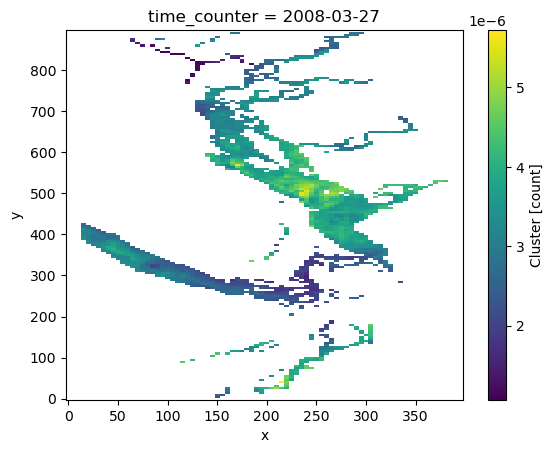

In [60]:
clusters[20].plot()

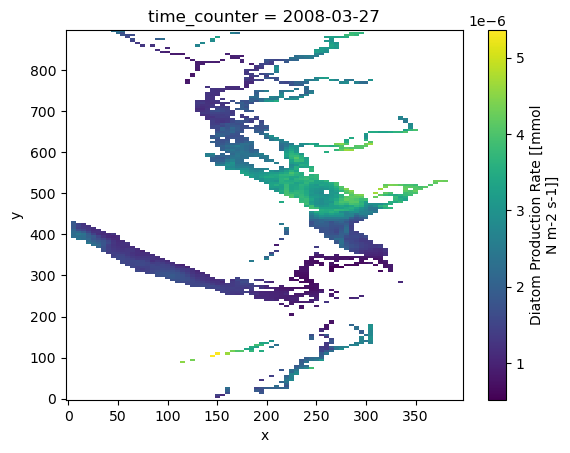

In [61]:
dataset.Diatom_Production_Rate[20].plot()